# CygnusX

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.rc('font', **{'family': 'serif', 'size': 20})
plt.rc('lines', linewidth = 2.5)
plt.rc('text', usetex=True)

INFO: Auto-setting vmin to  4.647e+21 [aplpy.core]
INFO: Auto-setting vmax to  2.983e+22 [aplpy.core]


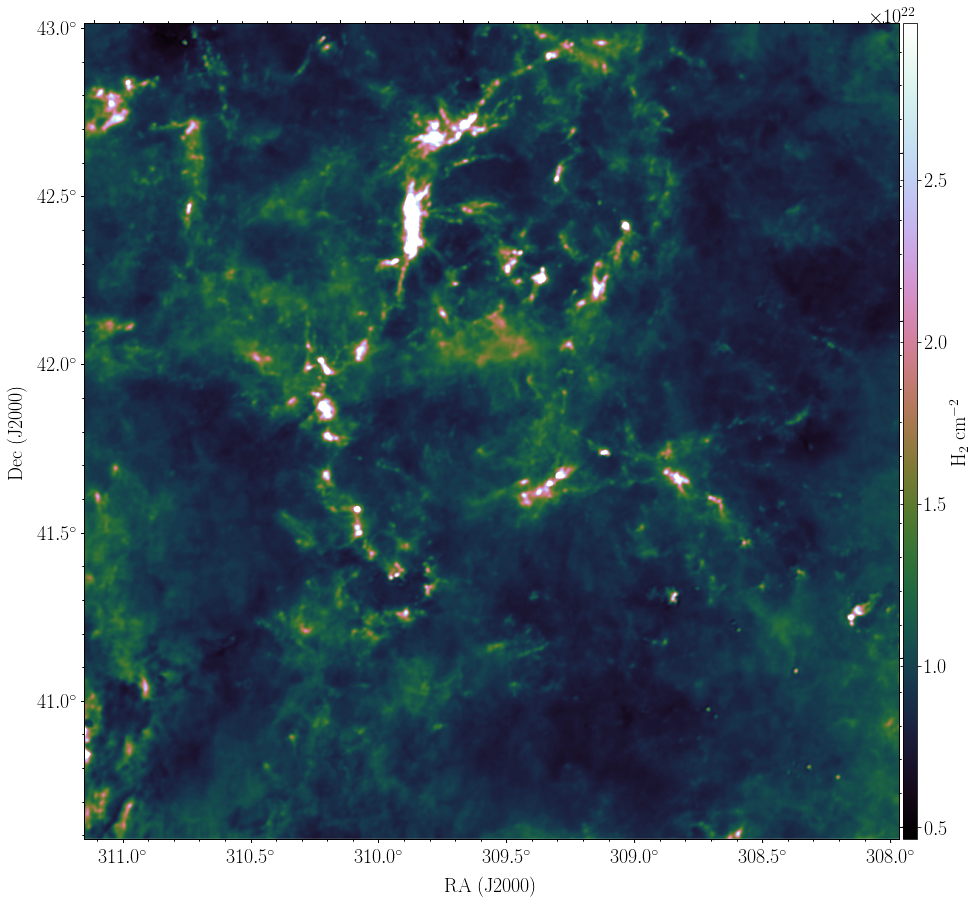

In [4]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/HOBYS_coldens/dr21_coldens_cf_r500_medsmo3.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [5]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

#Remove NaN
im[np.where(im != im)] = 0.

In [7]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

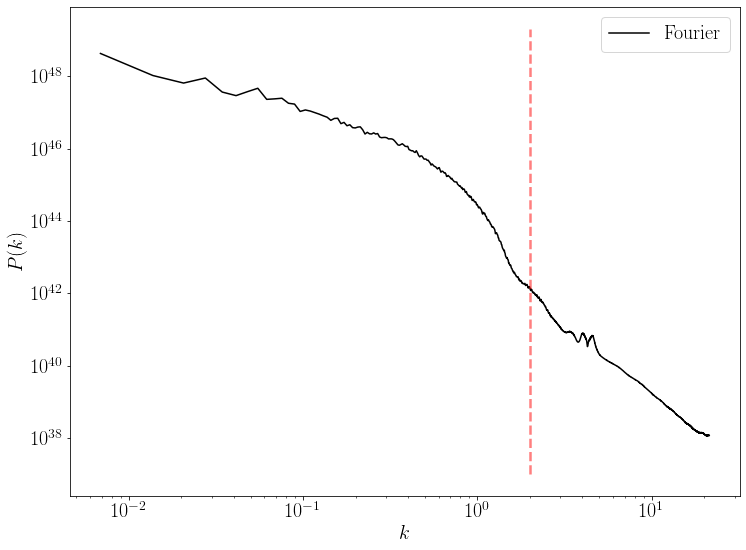

In [20]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper

#Fourier power spectrum
#tab_k, spec_k = powspec(imt, reso=reso)

#Plot
plt.figure(figsize=(12,9))
plt.plot(tab_k, spec_k, color='black',label='Fourier', linewidth=1.5)
plt.plot([2.,2.],[1e37,2e49],'--',color='red',alpha=0.5,)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.legend()

### Reprojection à la taille des pixels 500 $\mu$m

In [25]:
from pywavan.rebin import congrid

In [133]:
hdproj = header.copy()

pixsiz = header['CDELT2']
print('Present pixel size:',pixsiz)

pix500 = 0.00388889
ratio = pix500/pixsiz
print('Ratio=',ratio)

newdim = np.array([im.shape[0]/ratio,im.shape[1]/ratio])

#Bin to 500 micron resolution
imrbin = congrid(im, newdim)

hdproj['CDELT1'] = -1.*pix500
hdproj['CDELT2'] = pix500
hdproj['CRPIX1'] = header['CRPIX1']/ratio
hdproj['CRPIX2'] = header['CRPIX2']/ratio
hdproj['NAXIS1'] = np.int(np.round(header['NAXIS1']/ratio))
hdproj['NAXIS2'] = np.int(np.round(header['NAXIS2']/ratio))
del hdproj['CD1_1'], hdproj['CD1_2'], hdproj['CD2_1'], hdproj['CD2_2']

fits.writeto('/Users/robitaij/postdoc/Herschel/HOBYS_coldens/dr21_coldens_cf_r500_medsmo3_proj.fits',imrbin, hdproj, overwrite=True)

Present pixel size: 0.00038888888888889
Ratio= 10.000002857142828


INFO: Auto-setting vmin to  4.373e+21 [aplpy.core]
INFO: Auto-setting vmax to  3.242e+22 [aplpy.core]


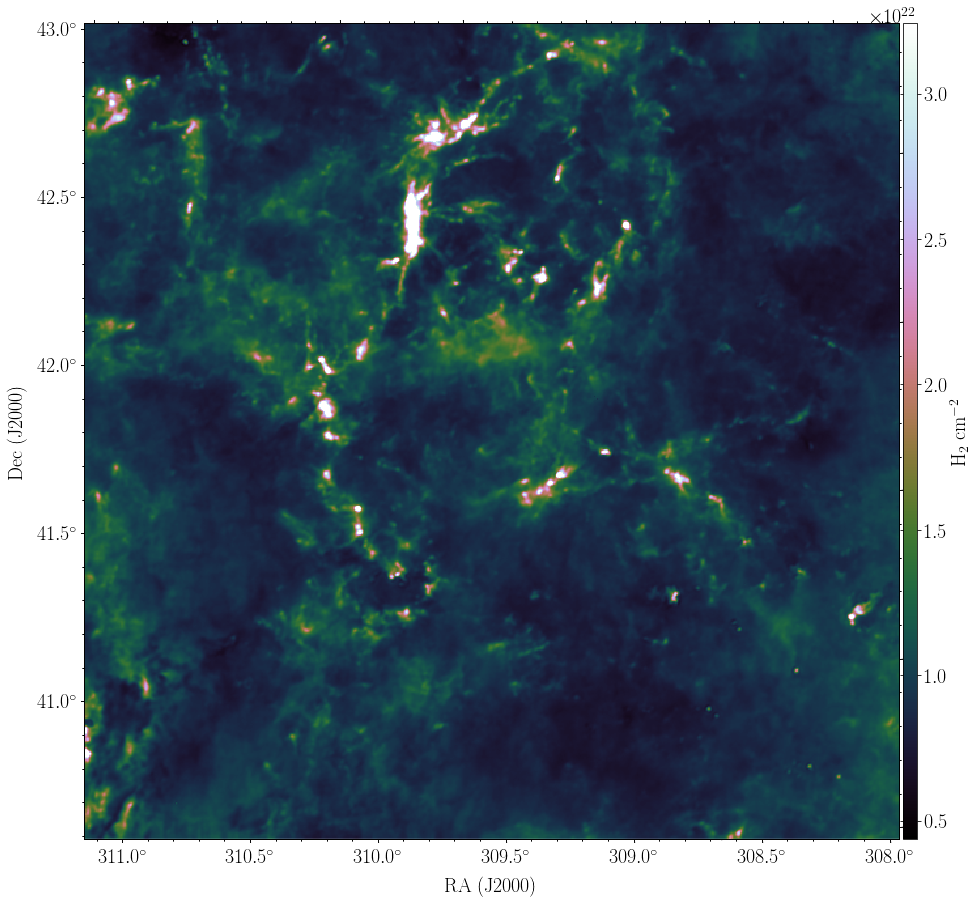

In [135]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/HOBYS_coldens/dr21_coldens_cf_r500_medsmo3_proj.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

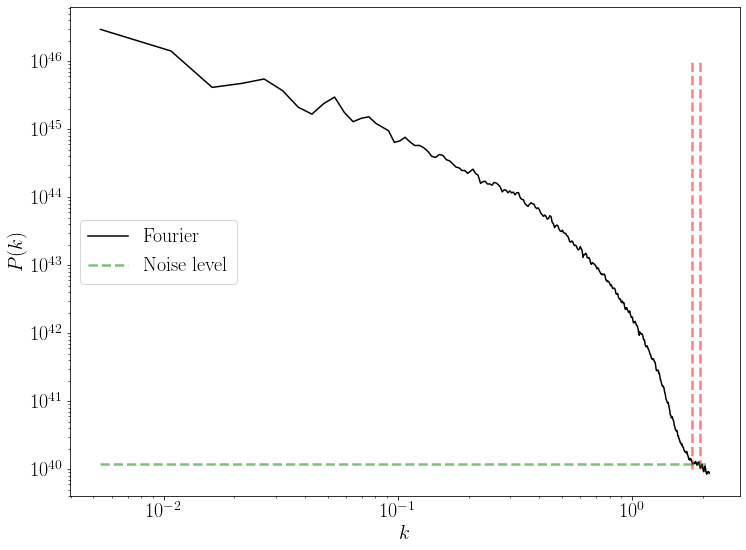

In [112]:
#Resolution in arcmin
reso = hdproj['CDELT2'] * 60.

na = imrbin.shape[1]
nb = imrbin.shape[0]
meanim = np.mean(imrbin)
imzm = imrbin - meanim

#Apodization
newdim = np.array((800,800))
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_kbin, spec_kbin = powspec(imr, reso=reso)

#Noise level
Noise = np.mean(spec_kbin[(tab_kbin > 1.8) & (tab_kbin < 1.95)])
#Noise = np.mean(spec_kbin[-1])

#Plot
plt.figure(figsize=(12,9))
plt.plot(tab_kbin, spec_kbin, color='black',label='Fourier', linewidth=1.5)
plt.plot([1.8,1.8],[1e40,1e46],'--',color='red',alpha=0.5,)
plt.plot([1.95,1.95],[1e40,1e46],'--',color='red',alpha=0.5,)
plt.plot([tab_kbin[0],tab_kbin[-1]],[Noise,Noise],'--',color='green',alpha=0.5,label='Noise level')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")
plt.legend()

### Wavelet power spectrum

In [35]:
#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imrbin, reso=reso, q=0, arrdim = newdim, smooth=False)

800 800


In [73]:
###Beam Fourier Power spectrum
#FWHM = 36. / (60.*reso)  #Beam size at 500 micron
#beam = gauss_beam(FWHM,newdim[0],newdim[1],FWHM=True)
beam = fits.open('/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])
tab_k, spec_beam = powspec(beamr, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

spec_kc = (spec_kbin - Noise) / spec_beamn

###Beam Wavelet Power spectrum
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
#del Bwt, BS11a, Bwav_k, Bq

BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0  #Spectrum normalisation

S1ac = (S1a - Noise) / BS1an

Power law fit
A, Gamma =  3.6689589314205134e+43 -1.3575757052752973
Uncertainties =  1.0346427868674652 0.01827140237776398


Text(0.5, 1.0, 'Cygnus X power spectrum')

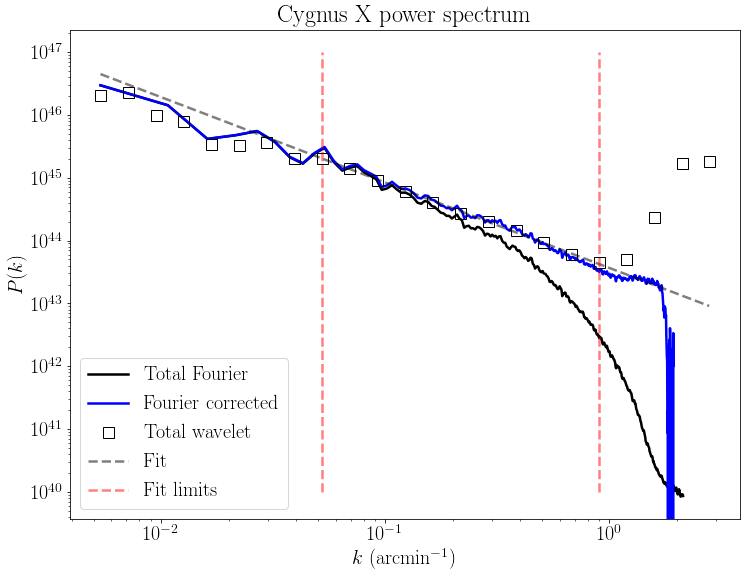

In [83]:
#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[8:18]), np.log(S1ac[8:18]),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_kbin, spec_kbin,color='black',label=r'Total Fourier')
plt.plot(tab_kbin, spec_kc,color= 'blue',label=r'Fourier corrected')
plt.plot(wav_k, S1ac,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, fit,'--',color='black',label=r'Fit', alpha=0.5)
plt.plot([wav_k[8],wav_k[8]],[1e40,1e47],'--',color='red',alpha=0.5,label=r'Fit limits')
plt.plot([wav_k[18],wav_k[18]],[1e40,1e47],'--',color='red',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()
plt.title('Cygnus X power spectrum')

Text(0.5, 1.0, 'Beam power spectrum')

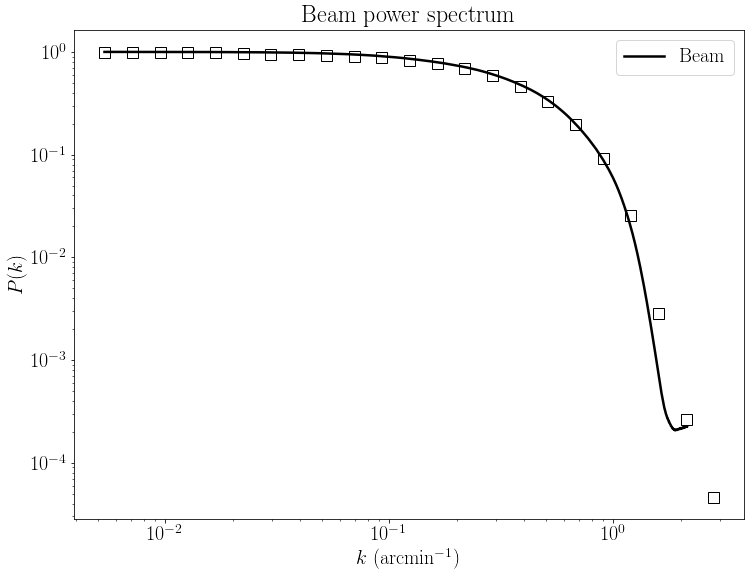

In [81]:
plt.figure(figsize(12,9))
plt.plot(tab_kbin, spec_beamn,color='black',label=r'Beam')
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()
plt.title('Beam power spectrum')

### Non-Gaussian segmentation

In [84]:
#Set a list of q (treshold parameter)
M = wav_k.size
q=[]
q=[2.5]*M

#Wavelet power spectrum
wt2, S11a2, wav_k, S1a2, q = fan_trans(imrbin, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=True)

800 800


In [113]:
S1a2c = (S1a2 - Noise) / BS1an

Gaussian Power spectrum
A, Gamma =  5.415843601303137e+40 -2.805924264276031
Uncertainties =  1.0456805365552193 0.01823670110083016


Text(0.5, 1.0, 'Cygnus X power spectrum')

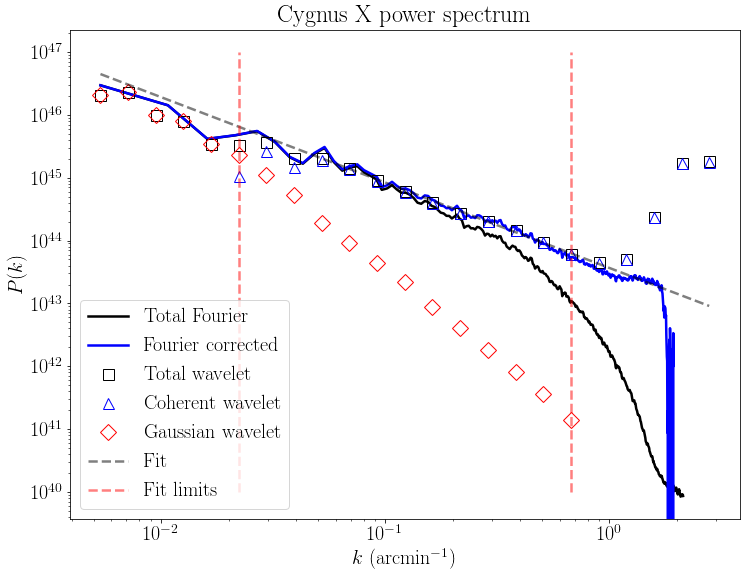

In [115]:
Ag, Gcov = np.polyfit(np.log(wav_k[5:17]), np.log(S1a2c[2,5:17]),deg=1,cov=True)
fitG = np.exp(Ag[1])*wav_k**Ag[0]
print('Gaussian Power spectrum')
print('A, Gamma = ', np.exp(Ag[1]), Ag[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(Gcov)[1])), np.sqrt(np.diag(Gcov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_kbin, spec_kbin,color='black',label=r'Total Fourier')
plt.plot(tab_kbin, spec_kc,color= 'blue',label=r'Fourier corrected')
plt.plot(wav_k, S1a2c[0],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, S1a2c[1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k, S1a2c[2],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, fit,'--',color='black',label=r'Fit', alpha=0.5)
plt.plot([wav_k[5],wav_k[5]],[1e40,1e47],'--',color='red',alpha=0.5,label=r'Fit limits')
plt.plot([wav_k[17],wav_k[17]],[1e40,1e47],'--',color='red',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()
plt.title('Cygnus X power spectrum')

In [106]:
coherent = np.sum(wt2[M:2*M,:,:],axis=0) + meanim
Gaussian = np.sum(wt2[2*M:3*M,:,:],axis=0) + meanim

fits.writeto('/Users/robitaij/postdoc/Herschel/HOBYS_coldens/analysis/dr21_coldens_cf_r500_cohe.fits',\
            coherent.real,hdproj,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/HOBYS_coldens/analysis/dr21_coldens_cf_r500_gaussian.fits',\
            Gaussian.real,hdproj,overwrite=True)

INFO: Auto-setting vmin to -3.251e+21 [aplpy.core]
INFO: Auto-setting vmax to  4.405e+21 [aplpy.core]
INFO: Auto-setting vmin to -6.787e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.933e+22 [aplpy.core]


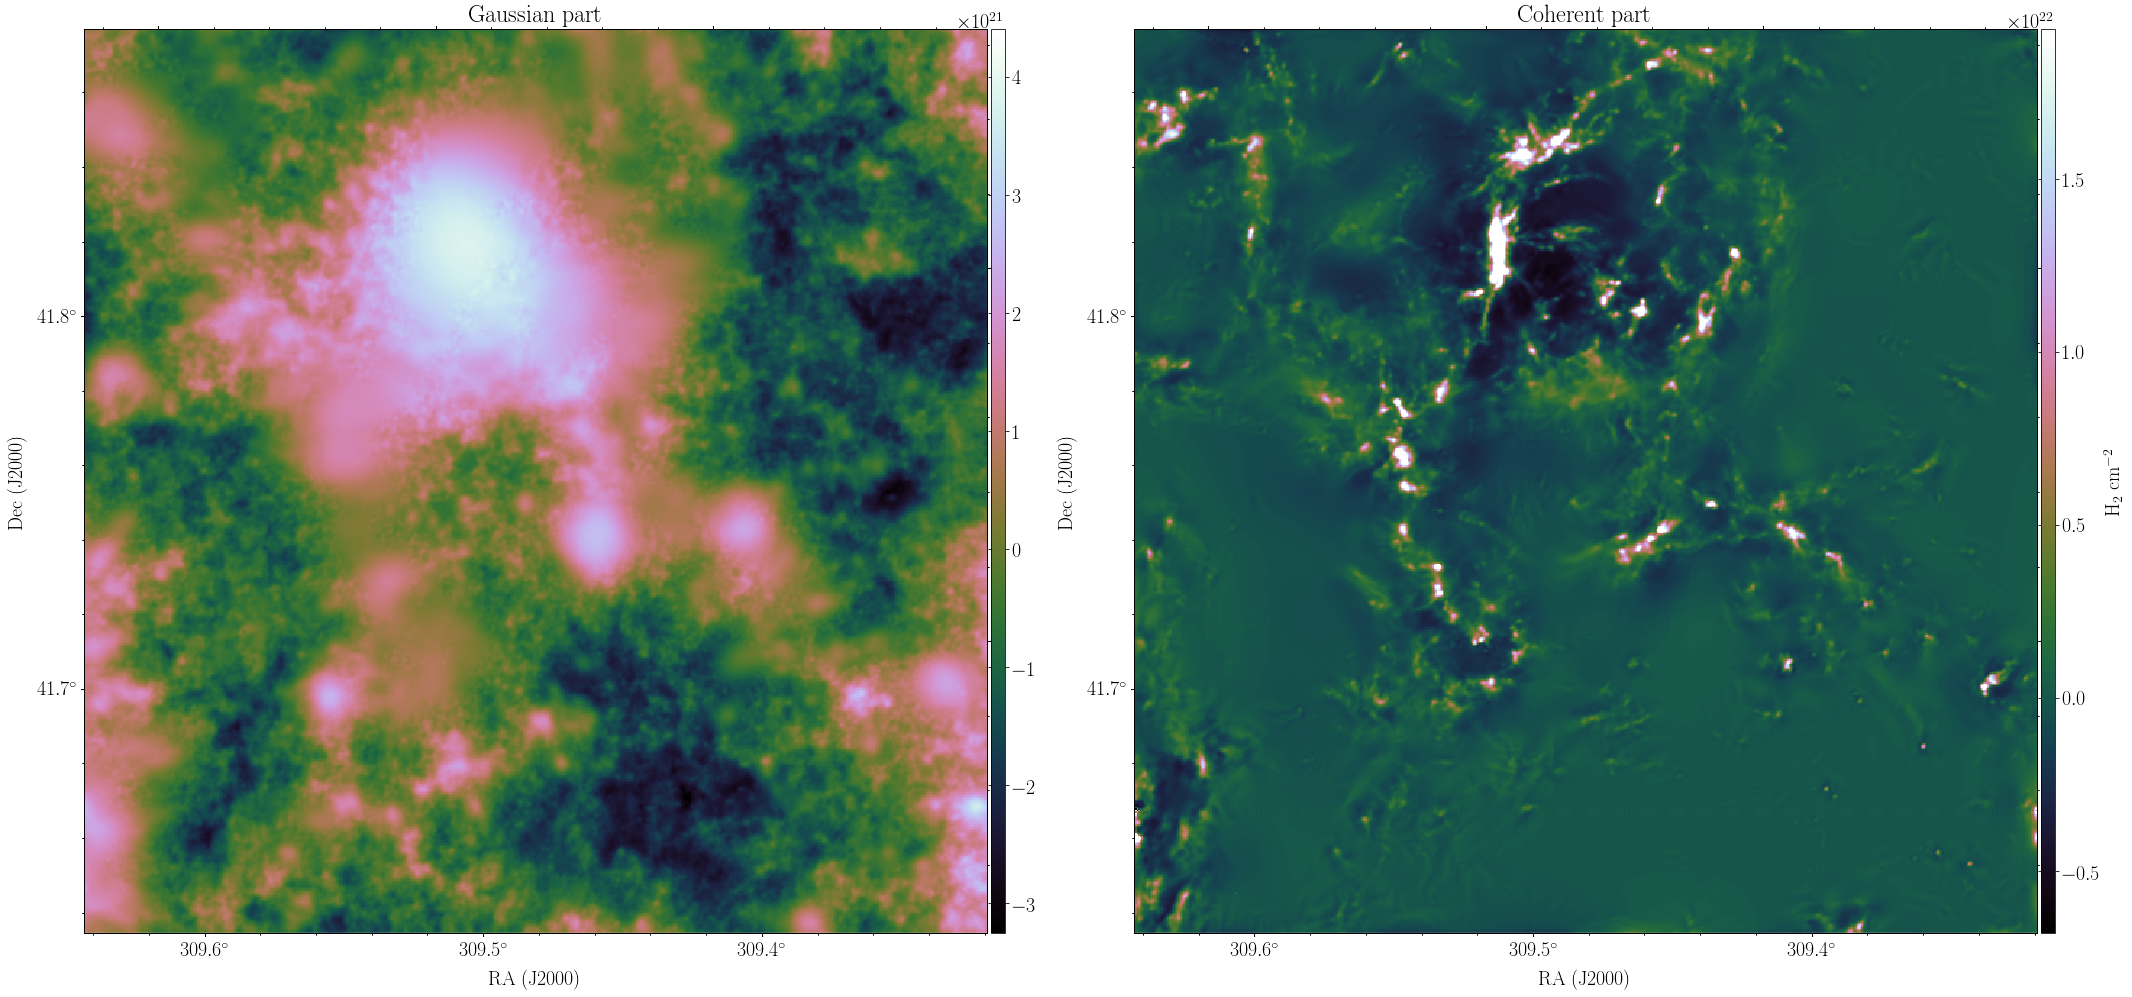

In [107]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/Users/robitaij/postdoc/Herschel/HOBYS_coldens/analysis/dr21_coldens_cf_r500_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title('Gaussian part')

figfile = '/Users/robitaij/postdoc/Herschel/HOBYS_coldens/analysis/dr21_coldens_cf_r500_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent part')

plt.tight_layout()

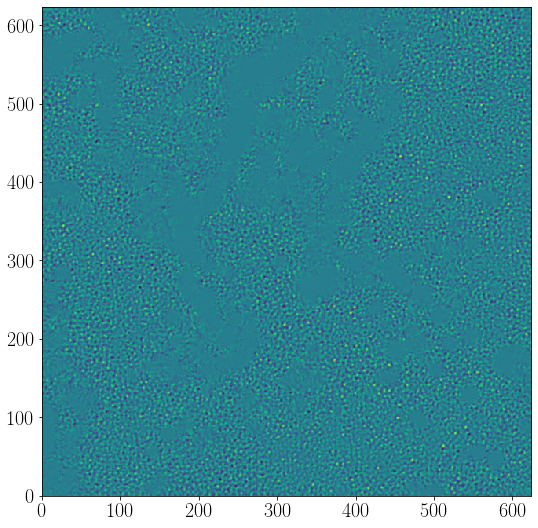

In [108]:
figure(figsize=(9,9))
imshow(np.sum(wt2[2*M+17:3*M,:,:],axis=0).real,origin='below')